# Modelling autocorrelation functions with scintools

In this tutorial we will look at how to measure scintillation parameters from the autocorrelation function (ACF) of a pulsar dynamic spectrum.

In [9]:
import sys
sys.path.insert(0, '/home/kris/Documents/research/scintillation_project/scintools/scintools/')

We start as usual by reading in the dynamic spectrum, in this case an observation of PSR J1603-7202 from Dec 15, 2009.

LOADING ./J1603-7202/s091215_183557.rf.pcm.dynspec...
...LOADED in 1.98 seconds

	 OBSERVATION PROPERTIES

filename:			s091215_183557.rf.pcm.dynspec
MJD:				55180.77546278648
Centre frequency (MHz):		1368.88
Bandwidth (MHz):		230.5
Channel bandwidth (MHz):	0.25
Integration time (s):		3839.99
Subintegration time (s):	60


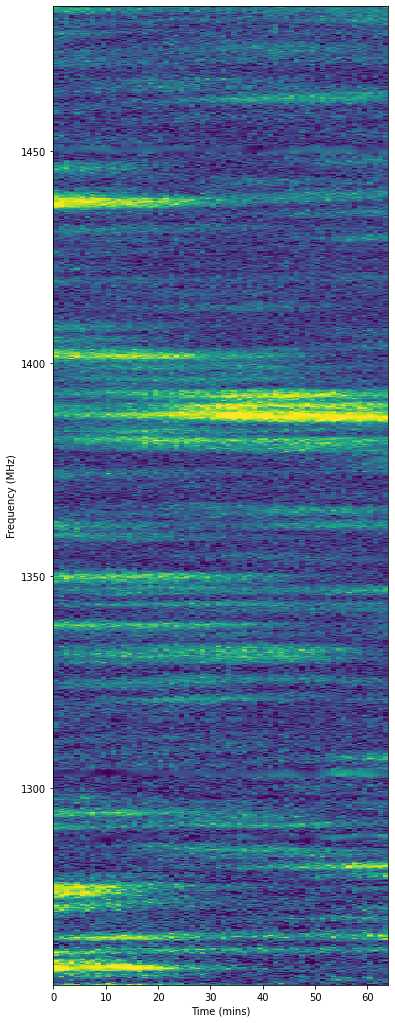

In [10]:
from dynspec import Dynspec  # The dynamic spectrum class

dyn_dir = './J1603-7202/'
dyn = Dynspec(filename=dyn_dir + 's091215_183557.rf.pcm.dynspec', process=True)
dyn.plot_dyn(figsize=(6,18))

To plot the autocorrelation function of the dynamic spectrum, we use the ``plot_acf`` method. This computes a function in frequency shift $\Delta\nu$ and time lag $\tau$ given by

$$\mathrm{ACF}(\Delta\nu,\tau)=\sum_{i=1}^{n_\nu-\frac{|\Delta\nu|}{\delta\nu}}\sum_{j=1}^{n_t-\frac{|\tau|}{\delta t}}S(\nu_i,t_j)S(\nu_i+\Delta\nu,t_j+\tau),$$

where $S(\nu, t)$ is the dynamic spectrum with $n_\nu$ channels and $n_t$ sub-integrations of width $\delta\nu$ and $\delta t$, respectively. 

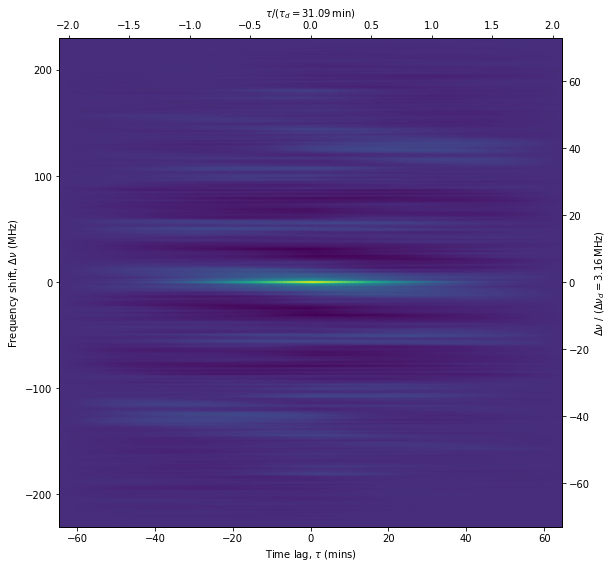

In [11]:
dyn.plot_acf()

It looks like the frequency scale of ACF is much smaller than the observation bandwidth. Let's crop this a bit:

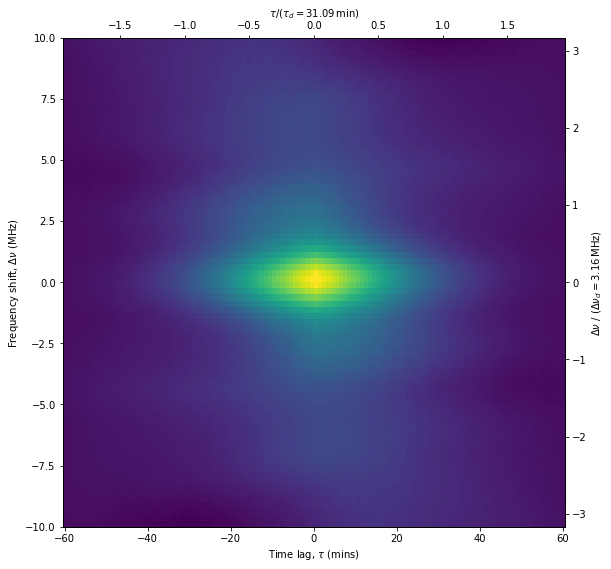

In [12]:
dyn.plot_acf(tlim=60, flim=10)

Much better!

The top and right axes are the time lag and frequency shift scaled by the scintillation timescale, $\tau_{\rm d}$, and decorrelation bandwidth, $\Delta\nu_{\rm d}$, respectively. We will now see how scintools measures these quantities.

The scintillation timescale is defined as the time lag at which the power decreases by a factor of $1/e$, while the decorrelation bandwidth

$\tau_{\rm d}$ and $\Delta\nu_{\rm d}$ are defined as the time lag and frequency shift at which the power is $1/e$ and $1/2$ times the amplitude (maximum power). We model these with the exponential functions

\begin{align}
P(\tau) &= A\exp\left[\left(\frac{\tau}{\tau_{\rm d}}\right)^\alpha\right]\tag*{(1)}\\P(\Delta\nu) &= A\exp\left[-\ln 2\frac{\Delta\nu}{\Delta\nu_{\rm d}}\right],\tag*{(2)}
\end{align}

where $\alpha$ is the spectral index (e.g. 2 corresponds to a Gaussian, 5/3 to a Kolmogorov spectrum, etc.).

The ``get_scint_params`` function with ``method='acf1d'`` fits Eq. 1 and 2 to 1D slices through the center of the ACF along each axis. Let's give it a try:

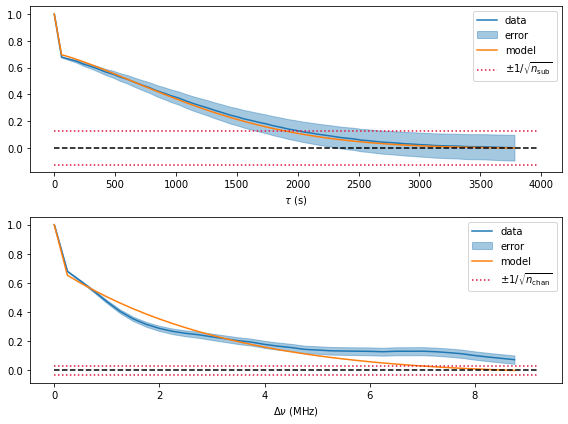

In [13]:
dyn.get_scint_params(method='acf1d', plot=True)

Looks good! And so we find that for our spectrum $\tau_{\rm d}=1870\pm 170\,\text{s}$ and $\Delta\nu_{\rm d}=3.2\pm 0.2\,\text{MHz}$.

However, while this 1D method works well for the nice and symmetrical ACF above, it is inappropriate for fitting ACFs that possess a significant phase gradient. Let's consider another observation of J1603-7202:

LOADING ./J1603-7202/r100106_165559.rf.pcm.dynspec...
...LOADED in 3.32 seconds

	 OBSERVATION PROPERTIES

filename:			r100106_165559.rf.pcm.dynspec
MJD:				55202.70601844893
Centre frequency (MHz):		1368.88
Bandwidth (MHz):		230.5
Channel bandwidth (MHz):	0.25
Integration time (s):		3779.98
Subintegration time (s):	60


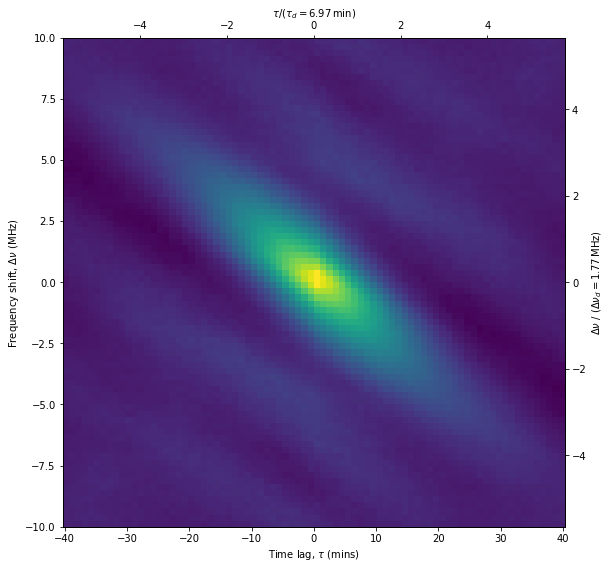

In [20]:
dyn2 = Dynspec(filename=dyn_dir + 'r100106_165559.rf.pcm.dynspec', process=True)
dyn2.plot_acf(tlim=40, flim=10)

This ACF has an obvious phase gradient and so 1D slices through the center cannot be modelled by Eq. 1 and 2.

For these cases, a 2D approximation can be fit to the ACF, given by

$$P(\tau,\Delta\nu)=A\exp\left[-\left(\left|\frac{\tau - \phi\Delta\nu}{\tau_{\rm d}}\right|^{3\alpha/2} + \left|\ln 2\frac{\Delta\nu}{\Delta\nu_{\rm d}}\right|^{3/2}\right)^{2/3}\right],$$

where $\phi$ is the phase gradient.

This is done by specifying ``method='acf2d_approx'`` in ``get_scint_params``. Since it's only the center power of the ACF that we care about fitting, we can choose to fit to a frame cropped to an ``nscale`` number of approximate scintillation timescales and decorrelation bandwidths. This prevents spurious power across the frame from biasing the fit and decreases computation time.

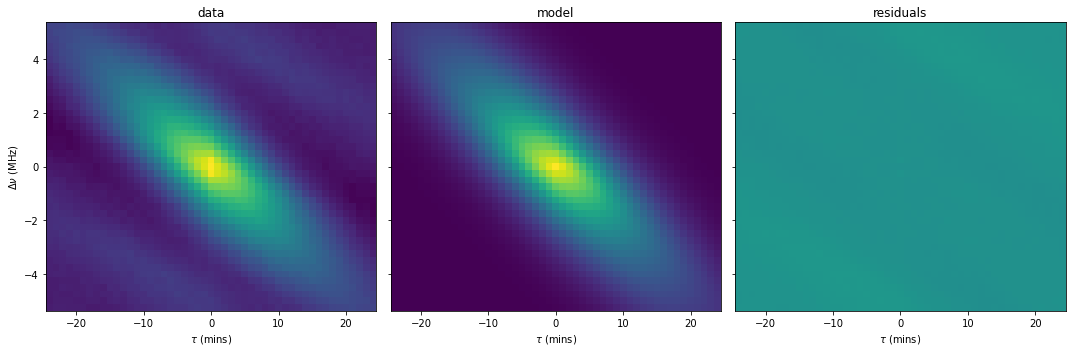

In [30]:
dyn2.get_scint_params(method='acf2d_approx', nscale=3, plot=True)

As well as the approximate model, scintools also features an implementation of the ACF model given by Equation 59 of [Lambert & Rickett, (1999)](doi.org/10.1086/307181) in its ``Simulation`` class (see the tutorial on simulating scintillation observations with scintools). The model involves evaluating a double integral of the phase structure function and so is significantly more computationally expensive than the approximate model, but it is useful for cases where the structure of the ACF is too complex for the approximate model to accurately capture.

Let's look at an observation with such an ACF.

LOADING ./J1603-7202/s091127_201249.rf.pcm.dynspec...
...LOADED in 2.19 seconds

	 OBSERVATION PROPERTIES

filename:			s091127_201249.rf.pcm.dynspec
MJD:				55162.84270810567
Centre frequency (MHz):		1368.88
Bandwidth (MHz):		230.5
Channel bandwidth (MHz):	0.25
Integration time (s):		3840.0
Subintegration time (s):	60


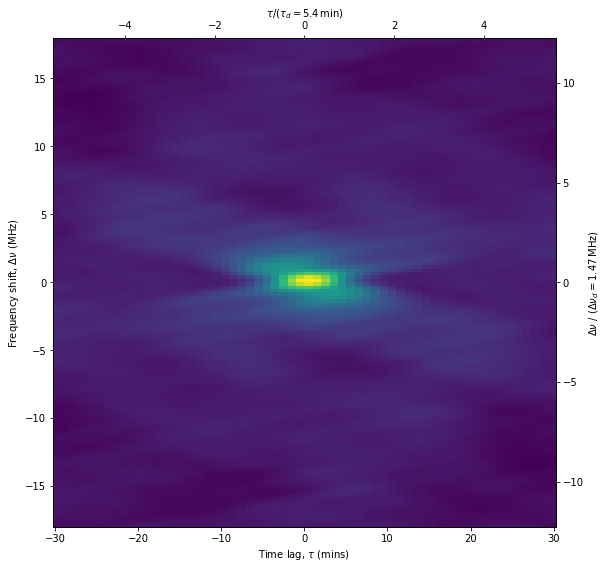

In [42]:
dyn3 = Dynspec(filename=dyn_dir + 's091127_201249.rf.pcm.dynspec', process=True)
dyn3.plot_acf(tlim=30, flim=18)

To fit with the Lambert & Rickett model, we specify ``method='acf2d'``:

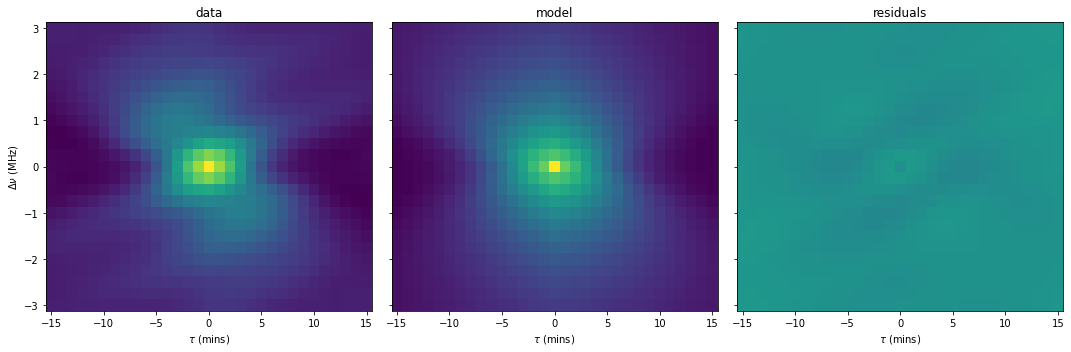

In [43]:
dyn3.get_scint_params(method='acf2d', nscale=3, plot=True)